In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/fast-text-word-embeddings/wiki-news-300d-1M.vec
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/fasttext/wiki.simple.vec
/kaggle/input/original-embeddings/GoogleNews-vectors-negative300(first500000).txt
/kaggle/input/original-embeddings/glove.6B.300d.txt


**Importing packages**

In [2]:
import re 
import nltk 
from nltk.corpus import stopwords 
from numpy import array 
from keras.preprocessing.text import one_hot 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model 
from keras.layers.core import Activation, Dropout, Dense 
from keras.layers import Flatten
from keras.layers import Conv1D 
from keras.layers import GlobalMaxPooling1D,MaxPooling1D
from keras.layers import LSTM,GRU
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split 
from keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors


**Reading the data**

In [3]:
train=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
train.shape

(50000, 2)

In [4]:
train.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
train.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


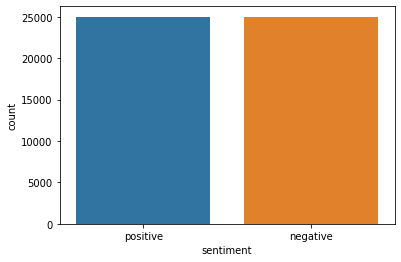

In [6]:
import seaborn as sns
ax=sns.countplot(x="sentiment", data=train)


In [7]:
train['review'].iloc[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [8]:
def remove_tags(text):
 return TAG_RE.sub('', text)
def preprocess_text(sen):
# Removing html tags
 sentence = remove_tags(sen)
# Remove punctuations and numbers
 sentence = re.sub('[^a-zA-Z]', ' ', sentence)
# Single character removal
 sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
# Removing multiple spaces
 sentence = re.sub(r'\s+', ' ', sentence)
 return sentence

TAG_RE = re.compile(r'<[^>]+>')


In [9]:
X = []
sentences = list(train['review'])
for sen in sentences:
 X.append(preprocess_text(sen))

In [10]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [11]:
y = train['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.20, random_state=42)

In [13]:
tokenizer = Tokenizer(num_words=5000) 
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 
maxlen = 100 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen) 
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
X_train

array([[   4,    1,  296, ...,  198,  345, 3812],
       [   1,  412,  100, ...,   82,   99,    6],
       [ 128, 1307,  108, ...,    0,    0,    0],
       ...,
       [ 778,    8,   24, ...,    0,    0,    0],
       [   8,  347,   10, ...,    0,    0,    0],
       [ 274,  100,  121, ...,   67,   69, 1946]], dtype=int32)

In [16]:
from numpy import array 
from numpy import asarray 
from numpy import zeros 
def embeddings(path):
    embeddings_dictionary = dict() 
    embeddings_file = open(path) 
    for line in embeddings_file:
        records = line.split()
        word = records[0] 
        vector_dimensions = asarray(records[1:],dtype='float32') 
        embeddings_dictionary[word] = vector_dimensions
    embeddings_file.close()
    return embeddings_dictionary
embeddings_dictionary=embeddings("../input/glove6b100dtxt/glove.6B.100d.txt")

In [17]:
embedding_matrix = zeros((vocab_size, 100)) 
for word, index in tokenizer.word_index.items(): 
    embedding_vector = embeddings_dictionary.get(word) 
    if embedding_vector is not None: 
        embedding_matrix[index] = embedding_vector


**A-Simple model**

In [18]:
def simple_model(X_train,y_train):
    model=Sequential()
    model.add(Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    model.compile("adam",loss='binary_crossentropy',metrics=["acc"])
    history=model.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model,history


In [19]:
model,history=simple_model(X_train,y_train)

2022-04-27 22:12:20.005838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 22:12:20.094146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 22:12:20.094973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 22:12:20.096291: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/6
250/250 [==============================] - 2s 3ms/step - loss: 0.6064 - acc: 0.6695 - val_loss: 0.5355 - val_acc: 0.7322
Epoch 2/6
250/250 [==============================] - 1s 2ms/step - loss: 0.5033 - acc: 0.7549 - val_loss: 0.5188 - val_acc: 0.7460
Epoch 3/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4610 - acc: 0.7833 - val_loss: 0.5304 - val_acc: 0.7381
Epoch 4/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4400 - acc: 0.7959 - val_loss: 0.5213 - val_acc: 0.7462
Epoch 5/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4242 - acc: 0.8064 - val_loss: 0.5478 - val_acc: 0.7341
Epoch 6/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4131 - acc: 0.8140 - val_loss: 0.5364 - val_acc: 0.7459


In [20]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.5411 - acc: 0.7415
Test Score: 0.5411254167556763
Test Accuracy: 0.7415000200271606


In [21]:
import matplotlib.pyplot as plt
def plotting(history):
    plt.plot(history.history['acc']) 
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left') 
    plt.show() 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left') 
    plt.show()


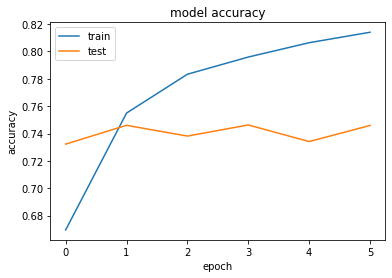

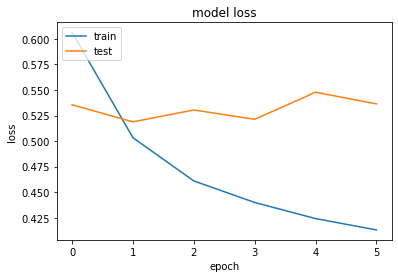

In [22]:
plotting(history)

**B-CNN model**

In [23]:
def model_cnn(X_train,y_train):
    model_cnn=Sequential()

    model_cnn.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen))
    model_cnn.add(Conv1D(128,5,activation='relu'))
    model_cnn.add(GlobalMaxPooling1D())
    model_cnn.add(Dense(1,activation='sigmoid'))
    model_cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_cnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_cnn,history

        

In [24]:
model_cnn,history=model_cnn(X_train,y_train)

Epoch 1/6


2022-04-27 22:12:30.620607: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


250/250 [==============================] - 8s 7ms/step - loss: 0.4720 - acc: 0.7712 - val_loss: 0.3549 - val_acc: 0.8435
Epoch 2/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3101 - acc: 0.8684 - val_loss: 0.3299 - val_acc: 0.8529
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.2453 - acc: 0.9025 - val_loss: 0.3384 - val_acc: 0.8564
Epoch 4/6
250/250 [==============================] - 2s 6ms/step - loss: 0.1989 - acc: 0.9261 - val_loss: 0.3162 - val_acc: 0.8651
Epoch 5/6
250/250 [==============================] - 2s 6ms/step - loss: 0.1502 - acc: 0.9503 - val_loss: 0.3217 - val_acc: 0.8664
Epoch 6/6
250/250 [==============================] - 2s 6ms/step - loss: 0.1058 - acc: 0.9730 - val_loss: 0.3435 - val_acc: 0.8629


In [25]:
score = model_cnn.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.3132 - acc: 0.8705
Test Score: 0.3131678104400635
Test Accuracy: 0.8705000281333923


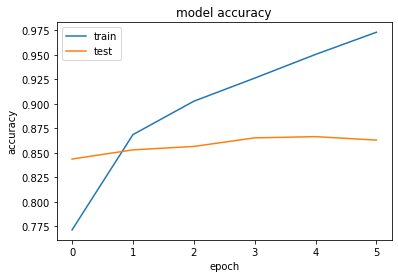

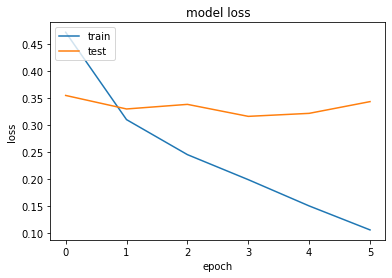

In [26]:
plotting(history)

**3-RNN model**

In [27]:
def model_RNN(X_train,y_train,l,embedding_matrix):
    model_rnn=Sequential()
    model_rnn.add(Embedding(vocab_size, l, weights=[embedding_matrix],input_length=maxlen))
    model_rnn.add(LSTM(128))
    model_rnn.add(Dense(1,activation='sigmoid'))
    model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_rnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_rnn,history

In [28]:
model_rnn,history=model_RNN(X_train,y_train,100,embedding_matrix)

Epoch 1/6
250/250 [==============================] - 5s 13ms/step - loss: 0.5277 - acc: 0.7258 - val_loss: 0.3895 - val_acc: 0.8344
Epoch 2/6
250/250 [==============================] - 3s 12ms/step - loss: 0.3385 - acc: 0.8546 - val_loss: 0.3274 - val_acc: 0.8564
Epoch 3/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2907 - acc: 0.8801 - val_loss: 0.3192 - val_acc: 0.8655
Epoch 4/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2552 - acc: 0.8962 - val_loss: 0.3608 - val_acc: 0.8634
Epoch 5/6
250/250 [==============================] - 3s 13ms/step - loss: 0.2316 - acc: 0.9078 - val_loss: 0.3489 - val_acc: 0.8595
Epoch 6/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2067 - acc: 0.9209 - val_loss: 0.3345 - val_acc: 0.8622


In [29]:
score = model_rnn.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3211 - acc: 0.8658
Test Score: 0.32110053300857544
Test Accuracy: 0.8658000230789185


In [30]:
predict_x=model_rnn.predict(X_test[7:8]) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[0]


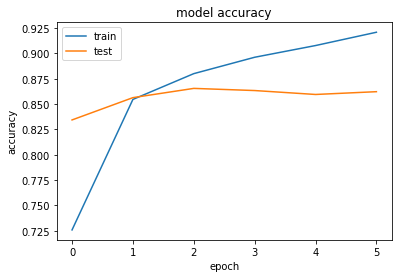

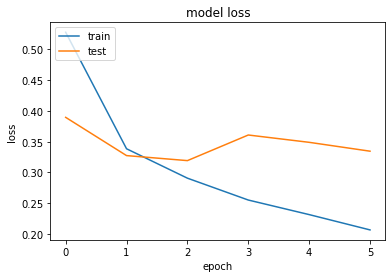

In [31]:
plotting(history)

**Classement des 3 models**
1. rnn
2. cnn
3. simple model

**RNN with GRU**

In [32]:
def model_GRU(X_train,y_train,l,embedding_matrix):
    model_rnn=Sequential()
    model_rnn.add(Embedding(vocab_size, l, weights=[embedding_matrix],input_length=maxlen))
    model_rnn.add(GRU(128))
    model_rnn.add(Dense(1,activation='sigmoid'))
    model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_rnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_rnn,history

In [33]:
m,h=model_GRU(X_train,y_train,100,embedding_matrix)

Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.4800 - acc: 0.7572 - val_loss: 0.3373 - val_acc: 0.8536
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3109 - acc: 0.8695 - val_loss: 0.3104 - val_acc: 0.8677
Epoch 3/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2627 - acc: 0.8928 - val_loss: 0.3326 - val_acc: 0.8633
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2327 - acc: 0.9069 - val_loss: 0.3185 - val_acc: 0.8681
Epoch 5/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2026 - acc: 0.9216 - val_loss: 0.3287 - val_acc: 0.8671
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.1720 - acc: 0.9360 - val_loss: 0.3658 - val_acc: 0.8604


In [34]:
score = m.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.3472 - acc: 0.8656
Test Score: 0.3471680283546448
Test Accuracy: 0.8655999898910522


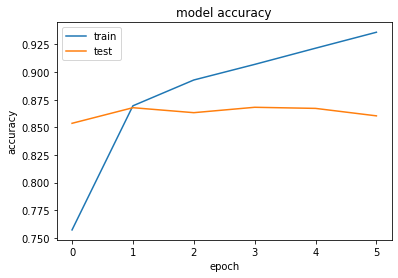

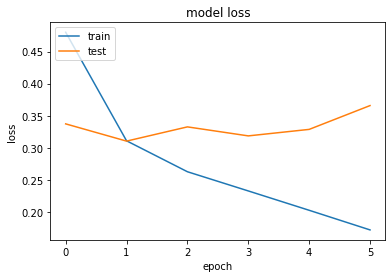

In [35]:
plotting(h)

**RNN+CNN**



In [36]:
def model_RNNCNN(X_train,y_train,l,embedding_matrix):
    modelx = Sequential()
    modelx.add((Embedding(vocab_size,l, weights=[embedding_matrix],input_length=maxlen)))
    modelx.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    modelx.add(MaxPooling1D(pool_size=2))
    modelx.add(LSTM(128))
    modelx.add(Dense(1, activation='sigmoid'))
    modelx.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history=modelx.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return modelx,history

In [37]:
x,h=model_RNNCNN(X_train,y_train,100,embedding_matrix)

Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.4915 - accuracy: 0.7512 - val_loss: 0.3728 - val_accuracy: 0.8413
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3125 - accuracy: 0.8685 - val_loss: 0.3232 - val_accuracy: 0.8612
Epoch 3/6
250/250 [==============================] - 3s 10ms/step - loss: 0.2637 - accuracy: 0.8921 - val_loss: 0.3521 - val_accuracy: 0.8456
Epoch 4/6
250/250 [==============================] - 3s 10ms/step - loss: 0.2254 - accuracy: 0.9122 - val_loss: 0.3129 - val_accuracy: 0.8698
Epoch 5/6
250/250 [==============================] - 3s 10ms/step - loss: 0.1780 - accuracy: 0.9330 - val_loss: 0.3434 - val_accuracy: 0.8684
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.1281 - accuracy: 0.9548 - val_loss: 0.3635 - val_accuracy: 0.8547


In [38]:
score = x.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3449 - accuracy: 0.8595
Test Score: 0.3448880612850189
Test Accuracy: 0.859499990940094


**Word2Vec**

In [39]:
word2vec=embeddings("../input/original-embeddings/GoogleNews-vectors-negative300(first500000).txt")

In [40]:
embedding_matrix1 = zeros((vocab_size, 300)) 
for word, index in tokenizer.word_index.items(): 
    embedding_vector = word2vec.get(word) 
    if embedding_vector is not None: 
        embedding_matrix1[index] = embedding_vector

In [41]:
embedding_matrix1

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [42]:
x1,his=model_RNNCNN(X_train,y_train,300,embedding_matrix1)

Epoch 1/6
250/250 [==============================] - 6s 19ms/step - loss: 0.4032 - accuracy: 0.8113 - val_loss: 0.3244 - val_accuracy: 0.8626
Epoch 2/6
250/250 [==============================] - 4s 17ms/step - loss: 0.2697 - accuracy: 0.8899 - val_loss: 0.3159 - val_accuracy: 0.8662
Epoch 3/6
250/250 [==============================] - 4s 17ms/step - loss: 0.2121 - accuracy: 0.9180 - val_loss: 0.3288 - val_accuracy: 0.8679
Epoch 4/6
250/250 [==============================] - 4s 17ms/step - loss: 0.1439 - accuracy: 0.9488 - val_loss: 0.3530 - val_accuracy: 0.8671
Epoch 5/6
250/250 [==============================] - 4s 17ms/step - loss: 0.0788 - accuracy: 0.9742 - val_loss: 0.4574 - val_accuracy: 0.8569
Epoch 6/6
250/250 [==============================] - 5s 18ms/step - loss: 0.0477 - accuracy: 0.9859 - val_loss: 0.5734 - val_accuracy: 0.8626


In [43]:
score = x1.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.5379 - accuracy: 0.8652
Test Score: 0.537851095199585
Test Accuracy: 0.8651999831199646


In [44]:
x2,his=model_RNN(X_train,y_train,300,embedding_matrix1)

Epoch 1/6
250/250 [==============================] - 6s 20ms/step - loss: 0.4109 - acc: 0.8098 - val_loss: 0.3360 - val_acc: 0.8565
Epoch 2/6
250/250 [==============================] - 5s 18ms/step - loss: 0.2958 - acc: 0.8771 - val_loss: 0.3287 - val_acc: 0.8611
Epoch 3/6
250/250 [==============================] - 5s 19ms/step - loss: 0.2569 - acc: 0.8940 - val_loss: 0.3687 - val_acc: 0.8499
Epoch 4/6
250/250 [==============================] - 5s 18ms/step - loss: 0.2199 - acc: 0.9142 - val_loss: 0.3557 - val_acc: 0.8490
Epoch 5/6
250/250 [==============================] - 5s 18ms/step - loss: 0.1850 - acc: 0.9291 - val_loss: 0.3837 - val_acc: 0.8546
Epoch 6/6
250/250 [==============================] - 5s 18ms/step - loss: 0.1480 - acc: 0.9457 - val_loss: 0.4673 - val_acc: 0.8501


In [45]:
score = x2.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.4599 - acc: 0.8535
Test Score: 0.45994794368743896
Test Accuracy: 0.8535000085830688


In [46]:
x3,his=model_GRU(X_train,y_train,300,embedding_matrix1)

Epoch 1/6
250/250 [==============================] - 6s 18ms/step - loss: 0.4208 - acc: 0.8019 - val_loss: 0.3328 - val_acc: 0.8576
Epoch 2/6
250/250 [==============================] - 4s 17ms/step - loss: 0.2861 - acc: 0.8837 - val_loss: 0.3194 - val_acc: 0.8671
Epoch 3/6
250/250 [==============================] - 4s 17ms/step - loss: 0.2368 - acc: 0.9068 - val_loss: 0.3176 - val_acc: 0.8643
Epoch 4/6
250/250 [==============================] - 4s 17ms/step - loss: 0.1954 - acc: 0.9261 - val_loss: 0.3617 - val_acc: 0.8597
Epoch 5/6
250/250 [==============================] - 4s 17ms/step - loss: 0.1574 - acc: 0.9430 - val_loss: 0.3698 - val_acc: 0.8556
Epoch 6/6
250/250 [==============================] - 4s 17ms/step - loss: 0.1207 - acc: 0.9581 - val_loss: 0.4599 - val_acc: 0.8446


In [47]:
score = x3.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.4284 - acc: 0.8530
Test Score: 0.42844268679618835
Test Accuracy: 0.8529999852180481


**Fasttext**

In [48]:
#FASTEXT_Embedding = KeyedVectors.load_word2vec_format('../input/fast-text-word-embeddings/wiki-news-300d-1M.vec')

In [49]:
from tqdm import tqdm

import os, re, csv, math, codecs

In [50]:
embeddings_index = {}
f = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

111052it [00:15, 7261.04it/s]

found 111052 word vectors


In [51]:
embedding_matrix2 = zeros((vocab_size, 100)) 
for word, index in tokenizer.word_index.items(): 
    embeddings_index = embeddings_dictionary.get(word) 
    if embeddings_index is not None: 
        embedding_matrix2[index] = embeddings_index


In [52]:
embedding_matrix2

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37771001,  0.22946   , -0.30311   , ..., -0.33610001,
         0.02637   , -0.72302002],
       [ 0.99882001,  0.044     ,  0.58508003, ..., -0.54869002,
         0.15141   ,  1.36880004]])

In [53]:
x11,his=model_RNNCNN(X_train,y_train,100,embedding_matrix2)

Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.4845 - accuracy: 0.7510 - val_loss: 0.4004 - val_accuracy: 0.8301
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3168 - accuracy: 0.8645 - val_loss: 0.3985 - val_accuracy: 0.8109
Epoch 3/6
250/250 [==============================] - 3s 10ms/step - loss: 0.2657 - accuracy: 0.8909 - val_loss: 0.3083 - val_accuracy: 0.8710
Epoch 4/6
250/250 [==============================] - 3s 10ms/step - loss: 0.2187 - accuracy: 0.9133 - val_loss: 0.3413 - val_accuracy: 0.8554
Epoch 5/6
250/250 [==============================] - 3s 10ms/step - loss: 0.1724 - accuracy: 0.9355 - val_loss: 0.3569 - val_accuracy: 0.8593
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.1191 - accuracy: 0.9593 - val_loss: 0.3628 - val_accuracy: 0.8524


In [54]:
score = x11.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3367 - accuracy: 0.8637
Test Score: 0.3366592824459076
Test Accuracy: 0.8636999726295471


In [55]:
x22,his=model_RNN(X_train,y_train,100,embedding_matrix2)

Epoch 1/6
250/250 [==============================] - 5s 14ms/step - loss: 0.5046 - acc: 0.7452 - val_loss: 0.3619 - val_acc: 0.8426
Epoch 2/6
250/250 [==============================] - 3s 12ms/step - loss: 0.3301 - acc: 0.8600 - val_loss: 0.3233 - val_acc: 0.8596
Epoch 3/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2870 - acc: 0.8821 - val_loss: 0.3275 - val_acc: 0.8570
Epoch 4/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2520 - acc: 0.8994 - val_loss: 0.3370 - val_acc: 0.8629
Epoch 5/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2260 - acc: 0.9119 - val_loss: 0.3248 - val_acc: 0.8631
Epoch 6/6
250/250 [==============================] - 3s 12ms/step - loss: 0.2043 - acc: 0.9224 - val_loss: 0.3507 - val_acc: 0.8621


In [56]:
score = x22.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3340 - acc: 0.8684
Test Score: 0.3339550197124481
Test Accuracy: 0.868399977684021


In [57]:
x33,his=model_GRU(X_train,y_train,100,embedding_matrix2)

Epoch 1/6
250/250 [==============================] - 5s 13ms/step - loss: 0.4803 - acc: 0.7535 - val_loss: 0.3836 - val_acc: 0.8284
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3090 - acc: 0.8674 - val_loss: 0.3137 - val_acc: 0.8673
Epoch 3/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2616 - acc: 0.8927 - val_loss: 0.3063 - val_acc: 0.8702
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2288 - acc: 0.9098 - val_loss: 0.3184 - val_acc: 0.8679
Epoch 5/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2039 - acc: 0.9212 - val_loss: 0.3223 - val_acc: 0.8684
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.1697 - acc: 0.9366 - val_loss: 0.3565 - val_acc: 0.8659


In [58]:
score = x33.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3367 - acc: 0.8716
Test Score: 0.3366602957248688
Test Accuracy: 0.8715999722480774


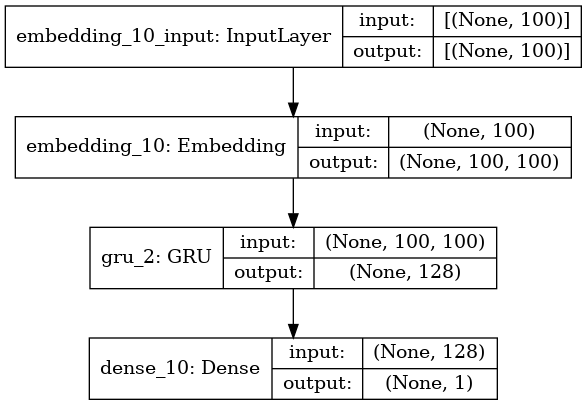

In [59]:
import tensorflow as tf
tf.keras.utils.plot_model(x33, show_shapes=True)


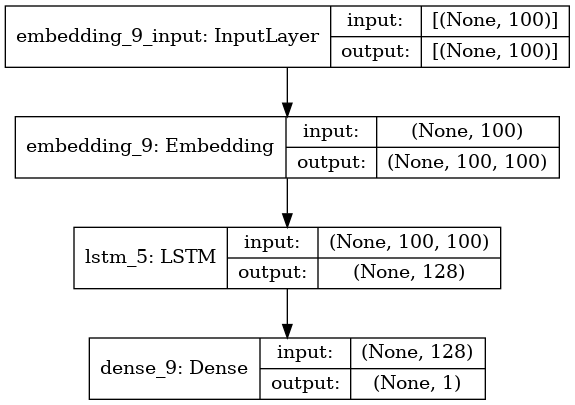

In [60]:
import tensorflow as tf
tf.keras.utils.plot_model(x22, show_shapes=True)

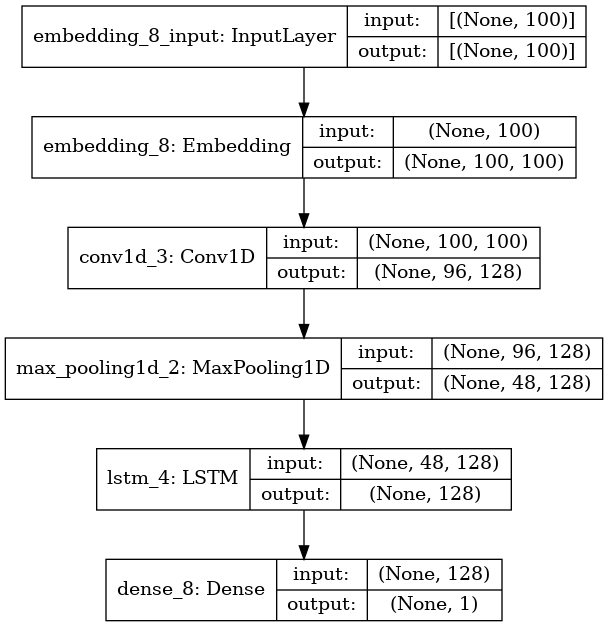

In [61]:
import tensorflow as tf
tf.keras.utils.plot_model(x11, show_shapes=True)

In [62]:
X

['One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare Forget pretty pictur

In [63]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer 
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(X)

In [64]:

word_count_vector.shape

(50000, 101372)

In [65]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
vect=tfidf_transformer.fit(word_count_vector)

In [66]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
the,1.008839
and,1.034611
of,1.052683
to,1.062364
this,1.099001
...,...
cinemascopes,11.126651
purposly,11.126651
purrrrrrrrrrrrrrrr,11.126651
biciclette,11.126651


In [67]:
dic=df_idf.to_dict()
w=dic['idf_weights']